In [31]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

## Get started with quantum singular value transformation

Quantum singular value transformation (QSVT) was recently proposed as a scheme that unifies several quantum algorithms.<sup>1</sup> QSVT enables you to carry out polynomial transformation of singular values of matrices. 

This tutorial covers the following:
- Background:
    - Quantum signal processing: How to encode a polynomial (single-qubit rotations)
    - Weierstrass theorem: Polynomial approximation of functions
    - Qubitization: Abstraction for viewing matrix operations as single-qubit rotations (using the block encoding scheme)
- Toy example: 
    - Search/amplitude amplification problem
    - How QSVT is used in a search problem

In this notebook, we discuss QSVT in the context of a search problem. For the search problem, we are given one or more marked items that we
have to search for. If the marked state is $\vert M \rangle$ and our initial state is $\lvert \psi_0 \rangle$, which has some initial overlap
with $\vert M \rangle$, that is, $|\langle M \rvert \psi_0 \rangle| = a$, then the goal of the search algorithm is to map $a \to 1.$ If $a$
is the singular value of a relevant matrix, then the goal of the QSVT algorithm is to implement a function $f(x)$ such that it transforms $a$ to $1.$

### Background
#### Quantum signal processing

QSVT borrows results from quantum signal processing (QSP), which prescribes how to encode polynomials using X and Z rotations
on the Bloch sphere. One such building block is the operator
$$
    W(x) = \begin{pmatrix}
    x & i\sqrt{1-x^2} \\
    i\sqrt{1-x^2} & -x
    \end{pmatrix}. \tag{1}
$$ 


$W(x)$ is then sandwiched between phase rotations to create another operator:
$$
W_{\Phi}(x):=e^{i \phi_{0} \sigma_{z}} W(x) e^{i \phi_{1} \sigma_{z}} W(x) \cdots W(x) e^{i \phi_{k} \sigma_{z}} \tag{2}
$$

$W_{\Phi}(x)$ can be used to encode a polynomial into a $2 \times 2$ matrix. 
Formally, it can be proven that there exists a set of phase angles $\phi \in \mathbb{R}^{k+1}$ such that 
$$
    W_{\Phi}(x)=\left(\begin{array}{cc}
    P(x) & i Q(x) \sqrt{1-x^{2}} \\
    i Q^{*}(x) \sqrt{1-x^{2}} & P^{*}(x)
    \end{array}\right), \tag{3} 
$$

where $P$ and $Q$ are polynomials with complex coefficients that satisfy the following conditions:
1. $\operatorname{deg}(P) \leq k$ and $\operatorname{deg}(Q) \leq k-1$,
2. $P$ has parity $k^* \bmod 2$ and $Q$ has parity $(k-1) \bmod 2$, and  
3. $\forall x \in[-1,1],|P(x)|^{2}+\left(1-x^{2}\right)|Q(x)|^{2}=1$. 

Note that we can rewrite $W(x)$ as X rotations, that is:

$$
W(x)=i e^{-i \sigma_{z} \pi / 4} R(x) e^{i \sigma_{z} \pi / 4}, \tag{4}
$$

where 

$$
R(x):=\left(\begin{array}{cc}
    x & \sqrt{1-x^{2}} \\
    \sqrt{1-x^{2}} & -x
    \end{array}\right). \tag{5}
$$

As a result, we can write $W_{\Phi}(x)$ (see Eq. 2) in terms of X and Z rotations:

$$
\begin{aligned}
    W_{\Phi}(x) &=e^{i \phi_{0} \sigma_{z}} \prod_{j=1}^{k} W(x) e^{i \phi_{j} \sigma_{z}} \\
    &=i^{k} e^{i \phi_{0} \sigma_{z}} \prod_{j=1}^{k} e^{-i \sigma_{z} \pi / 4} R(x) e^{i \sigma_{z}\left(\phi_{j}+\pi / 4\right)}.
\end{aligned} \tag{6}
$$

Note that using the scheme above, we can get only polynomial functions. In order to encode an arbitrary function transform, 
we need to find a polynomial that approximates such a function. The theorem below comes to our rescue.

#### Weierstrass approximation theorem
If $f$ is a continuous real-valued function defined on the real interval $[a, b]$, there exists a polynomial $P$ such that for all $x \in [a,b]$, we have
$$
\begin{equation}
    \lvert f(x) - P(x) \rvert \le \epsilon
\end{equation}. 
$$

This theorem ensures that we can always find a polynomial approximation of a given function as long as the function is well-behaved. Let’s see this
in action in the code below. Here we have the same $W(x)$ and $e^{i\phi Z}$ as discussed above. The sequence of $\phi_i$ is taken from Martyn et al. 2021 [[1]](#martyn)
and, when encoded into the Z rotations, gives us the plot for the sign function. We will use this sign function for the QSVT-based search below.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#the sequence of phase angles (see Eq. 6)
phi = [0.01558127, -0.01805798, 0.05705643, -0.01661832,
0.16163773, 0.09379074, -2.62342885, 0.49168481, 
0.92403822, -0.09696846, -0.09696846, 0.92403822,
0.49168481, -2.62342885, 0.09379074, 0.16163773, 
-0.01661832, 0.05705643, -0.01805798, 1.5863776]


def W(x):
    """
    The W(x) operator as defined above in Eq. 1
    """

    return np.matrix([[x, 1j * np.sqrt(1 - x**2)],
                   [1j * np.sqrt(1 - x**2), x]])

def rZ(theta):
    """
    The Z-rotation
    """
    
    return np.matrix([[np.exp(-1j * theta), 0],
                   [0, np.exp(1j * theta)]])

def end_m(x):
    """
    Alternate blocks of W(x) and Rz (see Eq. 2)
    """
    
    ans = rZ(phi[0]) 
    for i in range(1, len(phi)):
        ans *= W(x) * rZ(phi[i])

    return ans

px = []
for i in np.arange(-1,1,0.01):
    px.append(end_m(i)[0,0])

plt.plot(np.arange(-1, 1, 0.01), px, '-o')
plt.xlabel('x')
plt.ylabel('$P(x)$')
plt.show()

We plot here the polynomial function that gets encoded after using the chosen phase angle sequence during QSP. The particular phase angle sequence is expected to encode a polynomial that approximates the sign function.  

#### Qubitization

What we have discovered so far applies only to single-qubit rotations, but as we mentioned, we want to implement polynomial transformations
to the singular values of matrices. Let’s discuss how we can lift results from the previous section for matrices that are larger than 
$2 \times 2$. 

For now, let’s assume that the given matrix $A$ has its singular value decomposition as

$$
A = \sum_{k} \sigma_k \lvert w_k \rangle \langle v_k \rvert, \tag{7}
$$

where $\sigma_k$ and $\{\lvert w_k \rangle, \lvert v_k \rangle\}$ denote singular value and singular vectors of $A$.

QSVT uses an abstraction called “qubitization,” where, after block encoding $A$ into a bigger unitary of the form $^{\dagger}$

$$
    U_A = \begin{array}{c} \Pi \\ \begin{array}{c} \tilde{\Pi} \\\quad \end{array} 
    \begin{pmatrix} A & . \\ . & .\end{pmatrix} \end{array}, \tag{8}
$$

you can lift the results from QSP, create a version of $W(x)$ (see Eq. 1), and carry out rotations in this abstracted 
2D subspace spanned by the eigenspace of $A$. Here, the location of $A$, determined by projectors $\Pi$ and $\tilde\Pi$, is defined as
$\tilde{\Pi} = |w_k\rangle \langle w_k|$ and $\Pi = |v_k\rangle \langle v_k|$. Hence,

$$A = \tilde{\Pi} U_A \Pi. \tag{9}$$

The phase rotations in the QSP sequence are replaced by another unitary:

$$
\Pi_{\phi} = e^{\phi (2\Pi - 1)}, \tag{10}
$$

where $\Pi$ is a projector on the singular vectors. It may sound abstract for now, but bear with us—we will consider 
the search problem example to make these definitions more concrete. For now, let’s state the theorem formally. 

##### Theorem

Given a block encoding of a matrix $A = \sum_k \sigma_k |w_k \rangle \langle v_k|$ in a unitary matrix $U$,
$$
    U_A = \begin{array}{c} \Pi \\ \begin{array}{c} \tilde{\Pi} \\\quad \end{array} 
    \begin{pmatrix} A & . \\ . & .\end{pmatrix} \end{array}, \tag{11}
$$

with the location of $A$ determined by projectors $\Pi$ and $\tilde\Pi$, and given the ability to realize projector-controlled phase shift 
operations $\Pi_\phi$ and $\tilde{\Pi}_\phi$, then, for odd $d$,

$$  
    \begin{aligned}
    U_{\vec\phi} &= \tilde{\Pi}_{\phi_{1}}  U_{A} \left[ \prod_{k=1}^{(d-1)/2} \Pi_{\phi_{2k}} U_{A}^\dagger \tilde{\Pi}_{\phi_{2k+1}}  
                                                    U_A  \right] \\ 
    &=  \begin{array}{c} \Pi \\ \begin{array}{c} \tilde{\Pi} \\ \quad \end{array} 
        \begin{pmatrix} {\rm Poly}^{({\rm SV})}(A) & . \\ . & .\end{pmatrix}\end{array}
    \end{aligned}, \tag{12}
$$
where $ {\rm Poly}^{({\rm SV})}(A)$ is defined for an odd polynomial as
$$
 {\rm Poly}^{({\rm SV})}(A) := \sum_{k} {\rm Poly}(\sigma_k) |w_k \rangle \langle v_k|, \tag{13}
$$
which applies a polynomial transform to the singular values of $A$. The polynomial is of degree at most $d$ and obeys the conditions of $P$ from 
the theorem in Eq. 1.
            
Similarly, for $d$ even,
$$
\begin{aligned}
      U_{\vec\phi} &= \left[ \prod_{k=1}^{d/2} \Pi_{\phi_{2k-1}} U_{A}^\dagger \tilde{\Pi}_{\phi_{2k}}  U_A  \right] \\ 
    &=  \begin{array}{c} \Pi \\ \begin{array}{c} \tilde{\Pi} \\ \quad \end{array} 
        \begin{pmatrix} {\rm Poly}^{({\rm SV})}(A) & . \\ . & .\end{pmatrix}\end{array}
\end{aligned}, \tag{14}
$$

where $ {\rm Poly}^{({\rm SV})}(A)$ is defined for an even polynomial as
    $$
        {\rm Poly}^{({\rm SV})}(A) := \sum_{k} {\rm Poly}(\sigma_k) |v_k \rangle \langle v_k|, \tag{15}
    $$
which is also a polynomial transform of the singular values of $A$ but with the modification that the input and output spaces are both the 
right singular vector space spanned by $\{ |v_k \rangle \}$. Analogously, the polynomial is of degree at most $d$ and obeys the conditions of 
$P$ from the theorem in Eq. 1.

##### Implement $\Pi_{\phi}$

As discussed above (see Eq. 10), we need to implement $\Pi_{\phi} = e^{i \phi (2\Pi-1)}$ as a circuit. How we would do that?
You can write:
$$
\begin{split}
     e^{i\theta(2\Pi-1)} &= e^{i\theta2\Pi}e^{-i\theta} \\
     &= \big(I + (e^{2i\theta} -1)\Pi\big)e^{-i\theta} \\
     &= \big((I-\Pi) + e^{2i\theta}\Pi\big)e^{-i\theta} \\
     &= \big(e^{-i\theta}(I-\Pi) + e^{i\theta}\Pi\big).
\end{split} \tag{16}
$$

Hence, to implement $\Pi_{\phi}$, we need to implement projector-controlled-Z rotation. Say, if the projector $\Pi = |00\rangle \langle 00|$, then the
circuit below can implement $e^{i \phi (2\Pi-1)}$ up to a global phase.

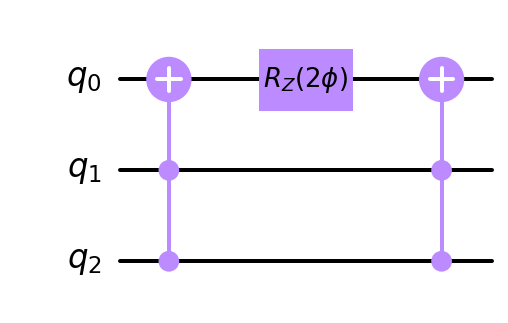

In [167]:
from qiskit import QuantumCircuit

def named_circ(name, nqubit, control=True):
    qc1 = QuantumCircuit(nqubit, name=name)
    if control:
        named_circ = qc1.to_gate().control(1)
    else:
        named_circ = qc1.to_gate()
    
    return named_circ


qc3 = QuantumCircuit(3)

qc3.mcx([1,2], target_qubit=0)
qc3.append(named_circ(r'$R_Z(2\phi)$', nqubit=1, control=False), [0])
qc3.mcx([1,2], target_qubit=0)

 
qc3.draw('mpl', scale=2.0)

### Toy example: Amplitude amplification/search problem

#### Problem definition

We state here a more general version of the search problem in the form of amplitude amplification. In these settings, given an initial 
state $|\psi_0\rangle$, if the marked state is $|M\rangle$, then the goal of the algorithm is to find a unitary 
$Q$ such that $|\langle M | Q |\psi_0 \rangle| \to 1$. Here, we have also been given access to $U_A$ and $U_A^{\dagger}$ such that 
$|\psi_0\rangle = U_A|\boldsymbol{0}\rangle.$

Note that any state $|\Psi\rangle$ can be written in the 2D vector space spanned by the orthogonal basis $\{| M \rangle, | M^{\perp} \rangle\}$ as
$$
|\Psi\rangle = \cos(\theta)| M \rangle + \sin(\theta)| M^{\perp} \rangle
.$$ 

Usually, we are given access to a “marking” unitary $U_M$ that marks the state $| M \rangle$; that is, when $U_M$ acts on a 
state $|\Psi\rangle = \cos(\theta)| M \rangle + \sin(\theta)| M^{\perp} \rangle$, 
we can write the mapping as 


$$
U_M \bigg(\cos(\theta)| M \rangle + \sin(\theta)| M^{\perp} \rangle\bigg) \mapsto -\cos(\theta)| M \rangle + \sin(\theta)| M^{\perp} \rangle 
.\tag{17}
$$  

We also assume that the initial overlap $|\langle M |\psi_0 \rangle| = |\langle M |U_A| 0 \rangle|$  is non-zero. Let’s denote the initial overlap  $|\langle M |U_A| 0 \rangle| = a.$ 

#### QSVT setup
In the QSVT scheme, we assume access to a slightly different “marking” unitary $U_M$. Here, $U_M = e^{i 2\theta |M\rangle\langle M| - 1}$. Note that from 
Eq. 16,

$$
e^{i 2\theta |M\rangle\langle M| - 1} = e^{-i\theta}(I-|M\rangle\langle M|) + e^{i\theta}|M\rangle\langle M|
.$$ 

Let’s observe its action on $|\Psi\rangle = \cos(\theta)| M \rangle + \sin(\theta)| M^{\perp} \rangle$. We get

$$
\begin{align}
   & \bigg[e^{-i\theta}(I-|M\rangle\langle M|) + e^{i\theta}|M\rangle\langle M|\bigg]|\Psi\rangle \\
   &= \bigg[e^{-i\theta}|M^{\perp}\rangle\langle M^{\perp}| + e^{i\theta}|M\rangle\langle M|\bigg]|\Psi\rangle \\
   &= e^{i\theta}\cos(\theta)| M \rangle + e^{-i\theta}\sin(\theta)| M^{\perp} \rangle.
\end{align} \tag{18}
$$

Notice how a phase with an opposite sign gets appended to the two orthogonal vectors $\{| M \rangle, | M^{\perp} \rangle\}$. When $\theta = \pi$, we 
recover the canonical “marking” unitary mentioned in Eq. 17. 

As discussed above, QSVT transforms singular values of a matrix. The natural question that arises is, what is $A$ in these settings? 

We can write:
$$
A = \Pi_{M} \Pi_{\psi_0} = a |M\rangle \langle\psi_0|,\tag{19}
$$ 

where $\Pi_{\psi_0} = |\psi_0\rangle \langle \psi_0| = U_A|0\rangle \langle 0|U_A^{\dagger}$, $\Pi_{M} = |M\rangle \langle M|$.

As $U_A$, when it acts on $|\boldsymbol{0}\rangle$, creates a state with finite overlap with $|M\rangle$, we can write:

$$
    U_A|\boldsymbol{0}\rangle = a|M\rangle + \sqrt{1-a^2}|M^{\perp}\rangle.
$$

This quickly allows us to see $U_A$ as a block encoding of $A$. As a $2 \times 2$ matrix, $U_A$ can be written as 

$$
 U_A = a|M\rangle\langle \boldsymbol{0}| - a|M^{\perp}\rangle\langle \boldsymbol{0}^{\perp}| 
    + \sqrt{1-a^2}|M^{\perp}\rangle\langle \boldsymbol{0}| + \sqrt{1-a^2}|M\rangle\langle \boldsymbol{0}^{\perp}|.
$$

Actually, $U_A$ can be seen as a basis-transforming matrix that maps vectors in one Hilbert space spanned by basis $\{|M\rangle, |M^{\perp}\rangle\}$ to
another Hilbert space spanned by $\{|\boldsymbol{0}\rangle, |\boldsymbol{0}^{\perp}\rangle\}$.

Once we have the block encoding and the projectors, we need to figure out the sequence of phase angles $\phi$ in Eq. 14:

$$
U_{\vec\phi} = \tilde{\Pi}_{\phi_{1}}  U_{A} \left[ \prod_{k=1}^{(d-1)/2} \Pi_{\phi_{2k}} U_{A}^\dagger \tilde{\Pi}_{\phi_{2k+1}}  
                                                    U_A  \right].
$$
We use the phase angles provided in Martyn et al. 2021 [[1]](#martyn) for the sign function, as was shown in the figure above. Note that as the length of the $\phi$ sequence given in the paper is even, it means that the degree of the polynomial that it implements is odd. 
That’s why we use Eq. 12 instead of Eq. 14. Also, the phase rotation unitaries in this case are 
$\tilde{\Pi}_{\phi} = e^{i\phi (2|\boldsymbol{0}\rangle \langle \boldsymbol{0}| - 1)}$ and 
$\Pi_{\phi} = e^{i\phi (2|M\rangle \langle M| - 1)}$. 

#### Toy example: Implementation

Here, for the toy example, we choose $|\psi_0\rangle = R_Y(\theta) \otimes R_Y(\theta)|00\rangle$. Hence, $U_A = R_Y(\theta) \otimes R_Y(\theta)$. 
Also, we choose $|M\rangle = |11\rangle$. This is not a typical amplitude amplification setup where we are ignorant about the marked state and 
given only a “marked” unitary. Choosing $|M\rangle = |11\rangle$ allows us to think less about the “marking” unitary. We know $X \otimes X |00\rangle = |11\rangle$, 
hence

$$
e^{i2\phi \Pi{M}} = X \otimes X e^{i\phi (2|\boldsymbol{0}\rangle \langle \boldsymbol{0}| - 1)} X \otimes X.
$$ 

With all this discussion and the circuit
construct we have for $ e^{i\phi (2|\boldsymbol{0}\rangle \langle \boldsymbol{0}| - 1)}$ (see Eq. 16 and the circuit below), we are ready to implement the QSVT version of amplitude amplification.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer import Aer

##### Phase angles

In [173]:
phi = [0.01558127, -0.01805798, 0.05705643, -0.01661832,
0.16163773, 0.09379074, -2.62342885, 0.49168481, 
0.92403822, -0.09696846, -0.09696846, 0.92403822,
0.49168481, -2.62342885, 0.09379074, 0.16163773, 
-0.01661832, 0.05705643, -0.01805798, 1.5863776]

# We convert angles from W-convention to "reflection" convention. See ref[1]
for i in range(1, len(phi)-1):
    phi[i] = (phi[i] + np.pi/2.0)
    
phi[0] = np.pi/4
phi[-1] = phi[-1] + np.pi/4 

In [174]:
def run_qsvt_search(theta):
    
    qc = QuantumCircuit(3)
    d = len(phi) 
    
    for k in range(d//2, 0, -1):
        
        #apply \tilde{Pi}_{phi}
        qc.ry(theta, 1)
        qc.ry(theta, 2)
        qc.mcx([1,2], target_qubit=0)
        qc.rz(-2 * phi[2*k-1], 0)
        qc.mcx([1,2], target_qubit=0)
        qc.ry(-theta, 1)
        qc.ry(-theta, 2)
        
        qc.barrier()
         
        #apply Pi_{\phi}
        qc.x(1)
        qc.x(2)
        qc.mcx([1,2], target_qubit=0)
        qc.rz(-2 * phi[2*k-2], 0)
        qc.mcx([1,2], target_qubit=0)
        qc.x(1)
        qc.x(2)
        
    qc.ry(theta, 1)
    qc.ry(theta, 2)
        
    simulator = Aer.get_backend('statevector_simulator')
    result = simulator.run(qc).result()
    answer_X = result.get_statevector(qc)
    
    return qc, result, answer_X
    
def prepare_initial_state(theta):
    qc = QuantumCircuit(3)

    qc.ry(theta, 1)
    qc.ry(theta, 2)
    
    simulator = Aer.get_backend('statevector_simulator')
    result = simulator.run(qc).result()
    answer_X = result.get_statevector(qc)
    
    return qc, result, answer_X

def prepare_target_state():
    
    qc = QuantumCircuit(3)

    qc.x(1)
    qc.x(2)
    
    simulator = Aer.get_backend('statevector_simulator')
    result = simulator.run(qc).result()
    answer_X = result.get_statevector(qc)
    
    return qc, result, answer_X

##### Initial state

In [175]:
qc, result, X = prepare_initial_state(np.pi/2.0)
result.get_counts()
X

Statevector([ 0.5+0.j, -0. +0.j,  0.5+0.j, -0. +0.j,  0.5+0.j, -0. +0.j,
              0.5+0.j,  0. +0.j],
            dims=(2, 2, 2))


##### Final state

{'000': 0.058242524822936, '010': 0.058242524822937, '100': 0.058242524822937, '110': 0.82527242553119}


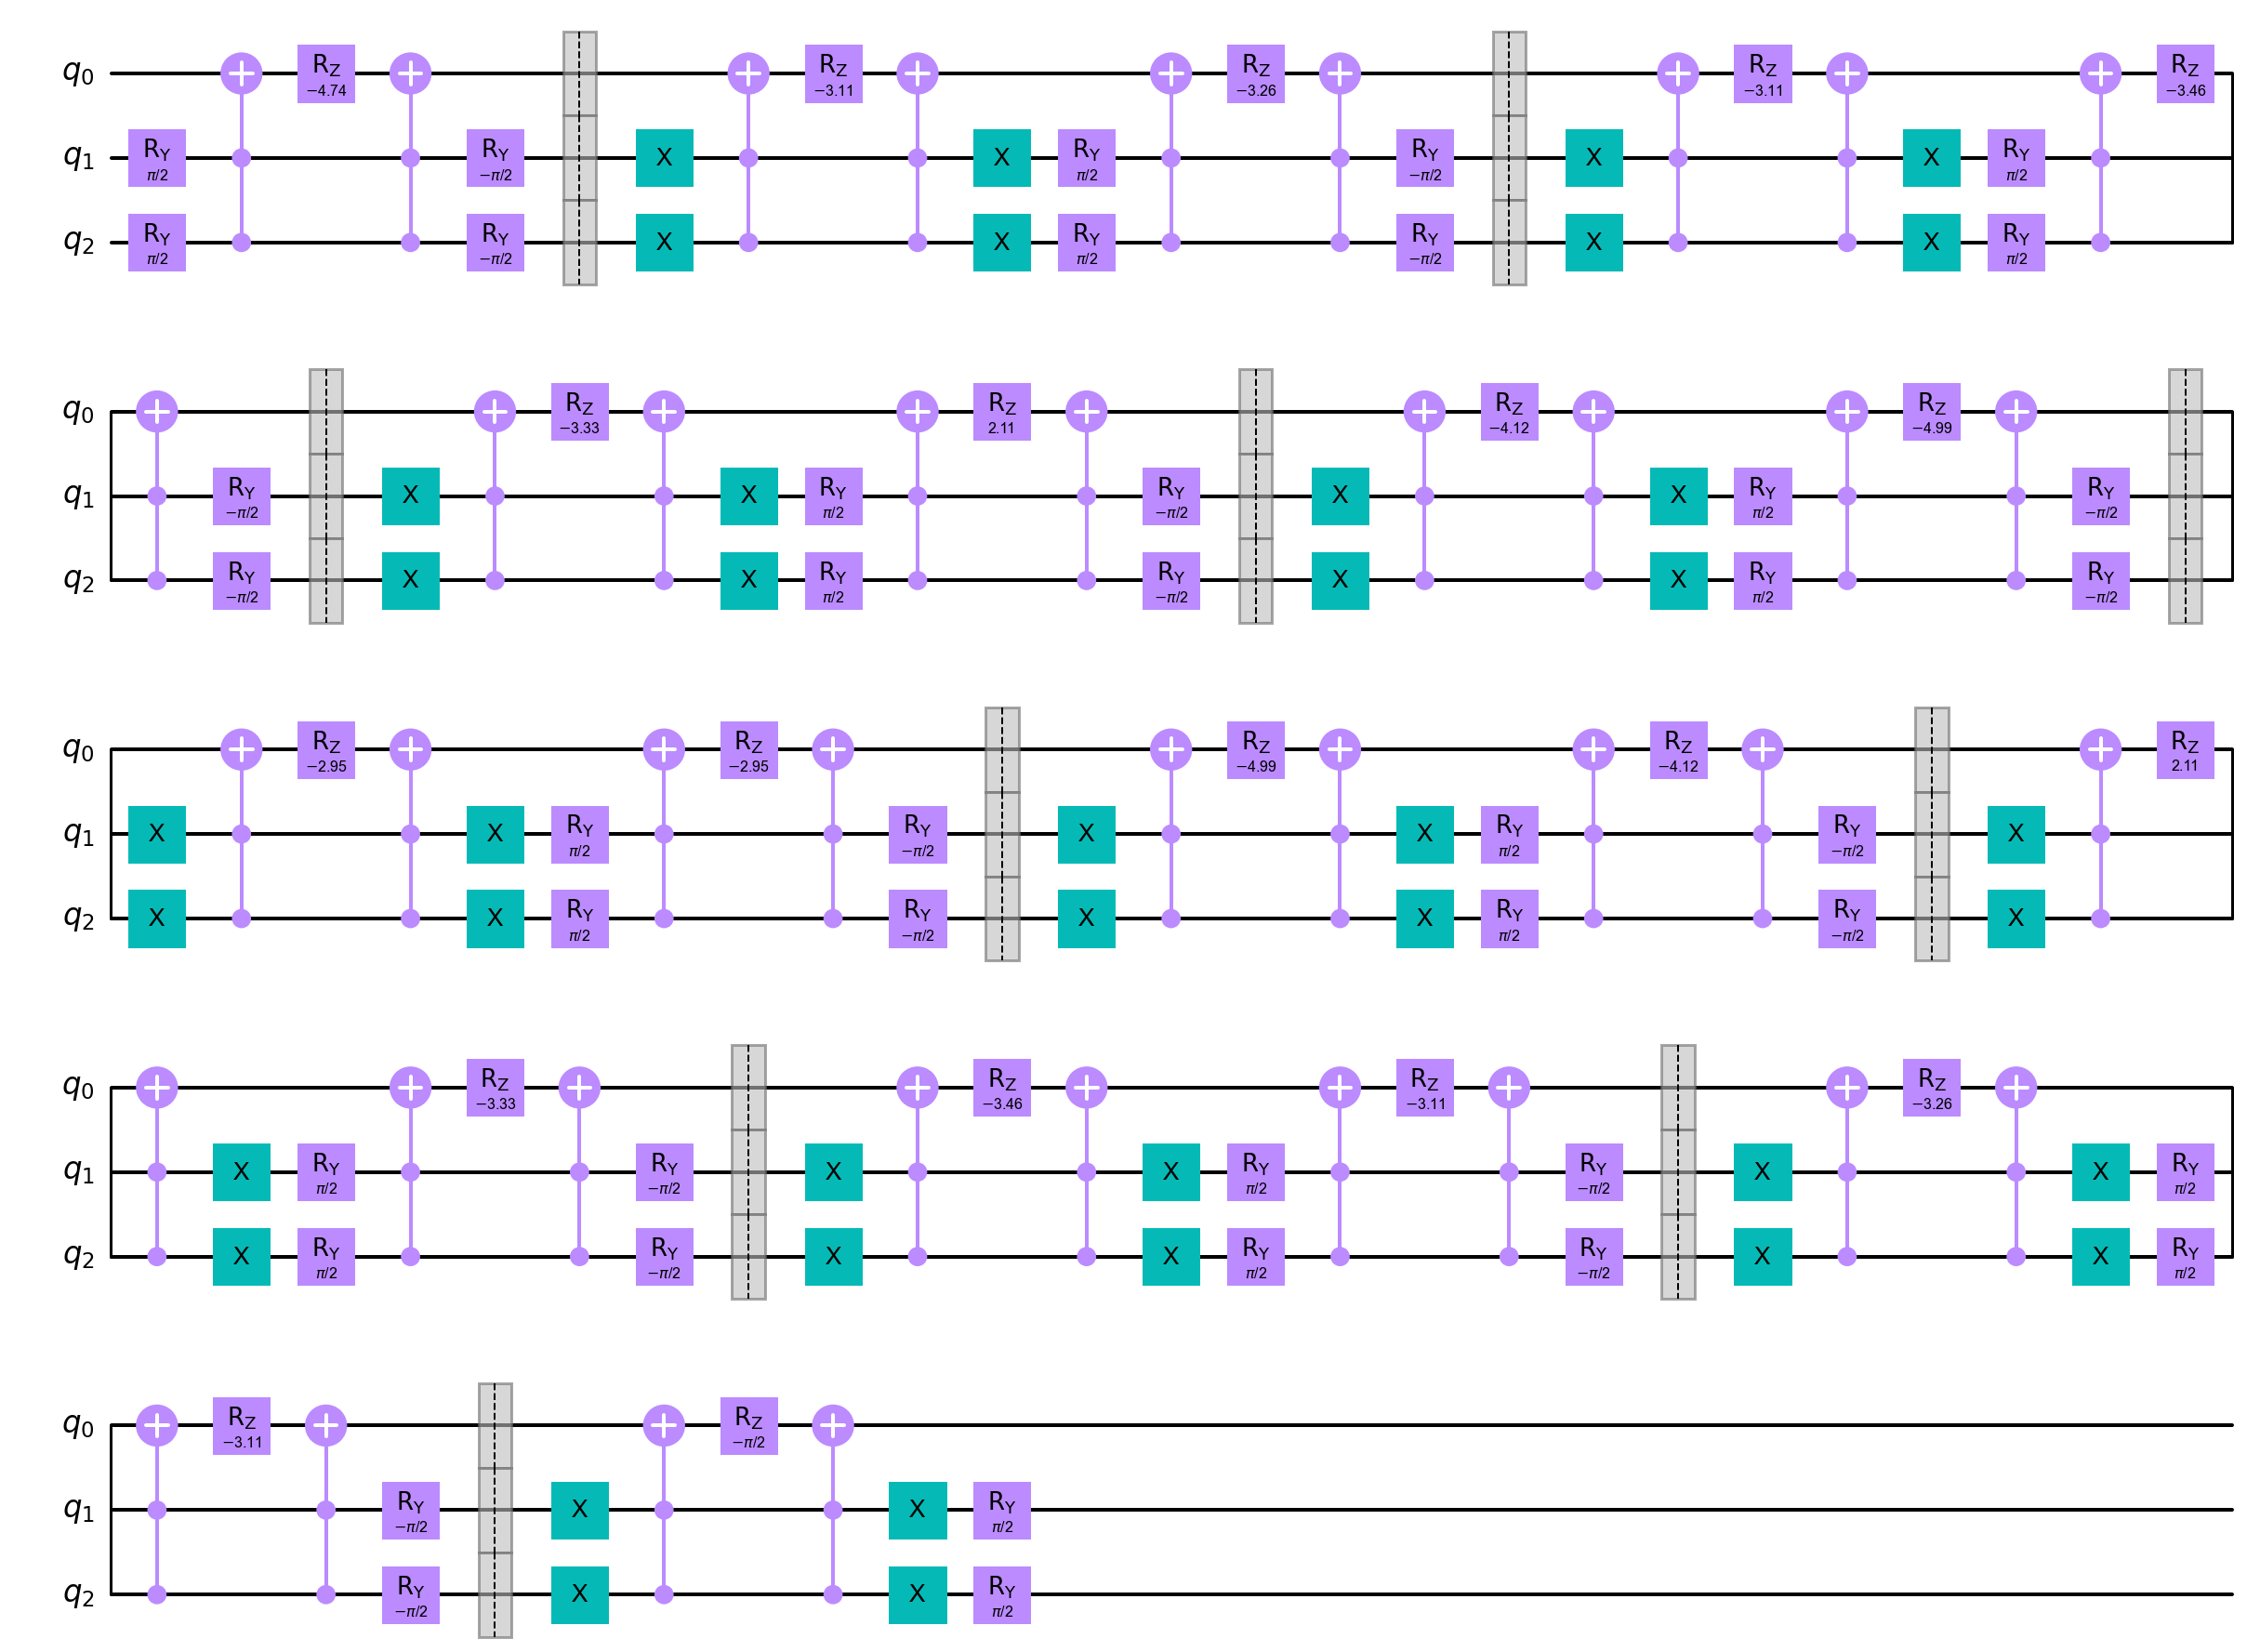

In [176]:
qc, result, X = run_qsvt_search(np.pi/2.0)

print(result.get_counts())
qc.draw('mpl', scale=2.0)

In [177]:
import collections

xfx = {}
for theta in np.arange(0, 2*np.pi, np.pi/32):
    if '110' in run_qsvt_search(theta)[1].get_counts().keys():
        fx = np.sqrt(run_qsvt_search(theta)[1].get_counts()['110'])
        x = np.sqrt(prepare_initial_state(theta)[1].get_counts()['110']) 
    else:
        fx = 0.0
        x = 0.0
                    
    xfx[x] = fx

#### Plot the final overlap versus the initial overlap

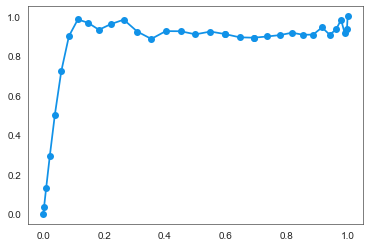

In [178]:
ordered_xfx = collections.OrderedDict(sorted(xfx.items()))
plt.plot(ordered_xfx.keys(), ordered_xfx.values(), '-o')

### Notes

\* An even function has a parity of 0, and an odd function has a parity of 1.

$\dagger$ Such unitaries that exactly block-encode $A$ are not always present. One then should work with a unitary that approximately 
block-encodes $A$<sup>1</sup> 

### Reference
    
1. <a name="martyn"></a>John M. Martyn et al. “Grand Unification of Quantum Algorithms.” *PRX Quantum* 2.040203 (2021): 1–40. https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.040203.

<span style="font-size:10pt; font-weight:bold;" class = "copyright-content"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>
